In [112]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
from tqdm import tqdm
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import joblib
import comet_ml
from comet_ml import Experiment
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F

# Sprawdzenie spojnosci jpg i csv

In [16]:
def validate_csv(csv_file, root_dir, output_csv):
    """
    Validate the CSV file by checking if the files exist in the dataset directory.
    Remove missing files and save a new CSV file.
    
    Args:
    - csv_file (str): Path to the input CSV file.
    - root_dir (str): Path to the dataset directory containing the images.
    - output_csv (str): Path to save the validated CSV file.
    """
    df = pd.read_csv(csv_file)
    
    valid_rows = []
    
    for idx, row in df.iterrows():

        img_path = os.path.join(root_dir, row[0])
        
        # Check if the file exists
        if os.path.exists(img_path):
            valid_rows.append(row)  # Keep valid rows
        else:
            print(f"File not found, skipping: {img_path}")
    

    valid_df = pd.DataFrame(valid_rows, columns=df.columns)
    

    valid_df.to_csv(output_csv, index=False)
    print(f"Validated CSV saved to {output_csv}")


csv_file = "wclasses.csv"   # Path to your original CSV file
root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"    # Path to your dataset directory
output_csv = 'validated_csv.csv'        # Path to save the new CSV file

validate_csv(csv_file, root_dir, output_csv)


C:\Users\Adas\AppData\Local\Temp\ipykernel_21044\674298775.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(root_dir, row[0])


File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_mending-the-sail-1896.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Naive_Art_Primitivism/grã©goire-michonze_figures-in-the-village(2).jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Naive_Art_Primitivism/grã©goire-michonze_figures-in-a-room-1981.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_boat-in-albufera-1908.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_raimundo-de-madrazo-in-his-paris-garden-1906.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Romanticism/pierre-

In [38]:
def split_csv(input_csv, train_csv, test_csv, train_ratio=0.99, random_seed=42):
    """
    Split a CSV file into training and testing datasets.

    Args:
    - input_csv (str): Path to the input CSV file.
    - train_csv (str): Path to save the training CSV file.
    - test_csv (str): Path to save the testing CSV file.
    - train_ratio (float): Ratio of data to be used for training (default is 0.99).
    - random_seed (int): Seed for random number generator to ensure reproducibility.
    """
    # Load the validated CSV file
    df = pd.read_csv(input_csv)

    # Shuffle the data with a fixed random seed
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # Calculate the split index
    split_idx = int(len(df_shuffled) * train_ratio)

    # Split into train and test datasets
    train_df = df_shuffled[:split_idx]
    test_df = df_shuffled[split_idx:]

    # Save the split datasets to CSV files
    train_df.to_csv(train_csv, index=False)
    test_df.to_csv(test_csv, index=False)

    print(f"Training data saved to {train_csv} ({len(train_df)} samples)")
    print(f"Testing data saved to {test_csv} ({len(test_df)} samples)")

# Paths to the output files
input_csv = 'validated_csv.csv'  # Path to the validated CSV file
train_csv = 'validate_csv_train.csv'  # Path to save the training CSV file
test_csv = 'validate_csv_test.csv'    # Path to save the testing CSV file

# Call the function to split the CSV
split_csv(input_csv, train_csv, test_csv)

Training data saved to validate_csv_train.csv (79868 samples)
Testing data saved to validate_csv_test.csv (807 samples)


In [15]:
#14.12

# 1. FEATURE EXTRACTOR

### DATASET AND DATALOADER

In [113]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Class
class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)  
        self.root_dir = root_dir
        self.transform = transform 
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])  
        image = Image.open(img_path).convert('RGB')  
        label = self.df.iloc[idx, 1]  

        if self.transform:
            image = self.transform(image) 

        return image, label  


In [114]:
# Dataset and DataLoader
root_dir = r"C:\Users\Hyperbook\.kaggle\wikiart dataset"
csv_file = "validate_csv_train.csv"

# Initialize Dataset and DataLoader
dataset = WikiArtDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# Use DataLoader for batching and shuffling
batch_size = 32
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=0, 
                        pin_memory=True)


# MODEL ARCHITECTURE

In [115]:
# Load Pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Define the new fully connected layer for latent space of size 200
latent_dim = 200

# Combine feature extractor and new FC layer
class ModifiedResNet18(nn.Module):
    def __init__(self, base_model):
        super(ModifiedResNet18, self).__init__()

        # Feature extractor
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        
        # Fully connected layer
        self.fc_layer = nn.Sequential(
            nn.Linear(512, latent_dim),
            nn.BatchNorm1d(latent_dim),  # normalizacja
            nn.Tanh(),                  # Czat powiedział ze tanh jest dobre do klasteryzaji kmeansem
        )

    def forward(self, x):
        # Feature extractor
        features = self.feature_extractor(x)
        # Flatten the features from [batch_size, 512, 1, 1] to [batch_size, 512]
        features = features.view(features.size(0), -1)
        # Fully connected 
        latent_space = self.fc_layer(features)
        return latent_space


### MODEL INITIALIZATION

In [116]:
# Initialize the modified ResNet-18 model
modified_resnet = ModifiedResNet18(resnet)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modified_resnet = modified_resnet.to(device)
modified_resnet

ModifiedResNet18(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

## EXTRACTING FEATURES

In [53]:
modified_resnet.eval()

latent_vectors = []
with torch.no_grad():  # Disable gradient computation for faster processing
    for images, labels in tqdm(dataloader, desc="Extracting Features"):
        images = images.to(device)
        latent_space = modified_resnet(images)  # Pass images through the modified model
        latent_vectors.append(latent_space.cpu())  # Move to CPU and store

# Combine all features into a single tensor
latent_vectors = torch.cat(latent_vectors, dim=0)

# Save Latent Vectors
torch.save(latent_vectors, "latent_vectors_200_michal.pt")


Extracting Features: 100%|██████████| 2496/2496 [36:11<00:00,  1.15it/s]


In [117]:
import torch
import numpy as np
from sklearn.decomposition import PCA

# Load latent vectors
latent_vectors = torch.load("latent_vectors_200_michal.pt")

# Convert latent vectors to NumPy for use in scikit-learn
latent_vectors = latent_vectors.numpy()

# Initialize PCA
pca = PCA()

# Fit PCA on latent vectors
pca.fit(latent_vectors)

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components required to retain at least 90% variance
num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to retain 90% variance: {num_components_90}")


pca_components = PCA(n_components=num_components_90)
reduced_latent_vectors = pca_components.fit_transform(latent_vectors)

# Save the reduced latent vectors
np.save("reduced_latent_vectors_200_michal.npy", reduced_latent_vectors)

# Save PCA model for later use if needed
import joblib
joblib.dump(pca_components, "pca_4_components_200_michal.pkl")

Number of components to retain 90% variance: 97


C:\Users\Hyperbook\AppData\Local\Temp\ipykernel_18892\4103829052.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vectors = torch.load("latent_vectors_200_michal.p

['pca_4_components_200_michal.pkl']

In [118]:
reduced_latent_vectors[0].size

97

## CLUSTERING VISUALIZATION

In [119]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(reduced_latent_vectors)

# Labels
labels = kmeans.labels_

print(f"Cluster labels:\n{np.unique(labels)}")

Cluster labels:
[0 1 2 3 4 5 6 7 8 9]


C:\Users\Hyperbook\AppData\Local\Temp\ipykernel_18892\2531665974.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('coolwarm', len(unique_labels))


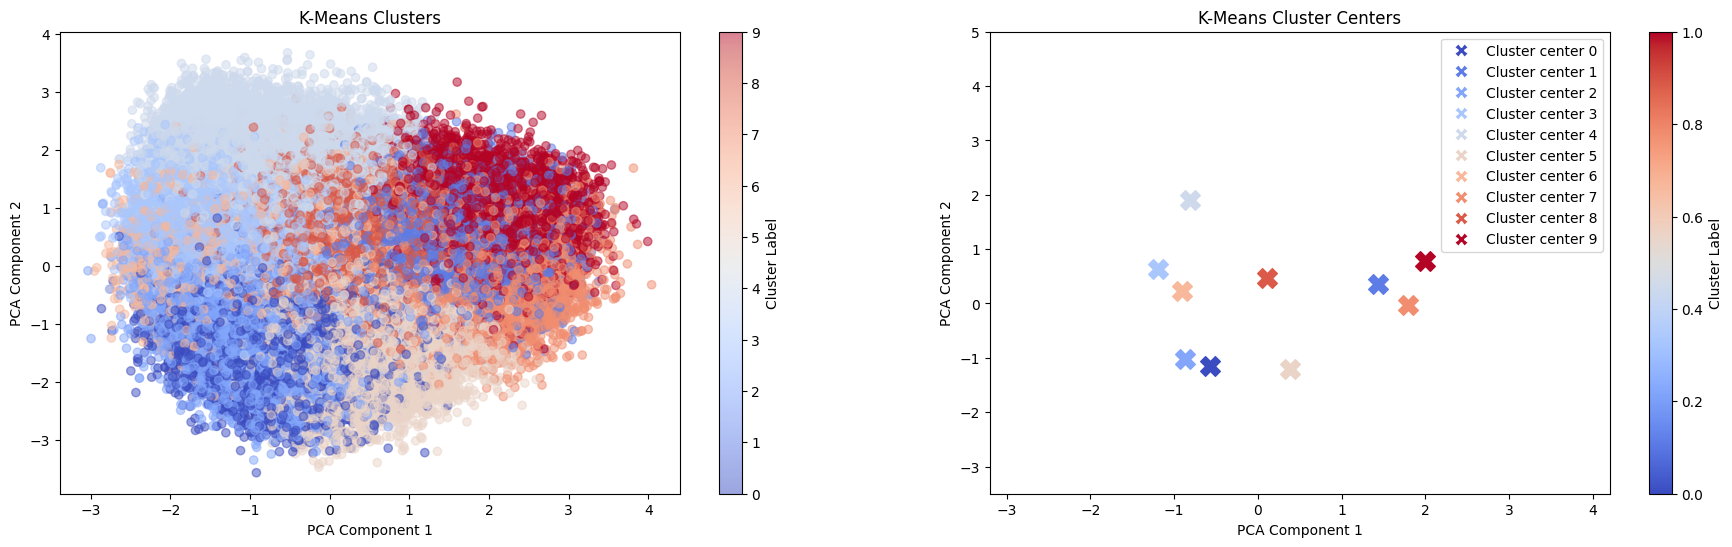

In [9]:
# Using PCA for visualization
pca_2d = PCA(n_components=2)

# Reduced vectors
reduced_vectors_2d = pca_2d.fit_transform(reduced_latent_vectors)

# Cluster centers
cluster_centers = kmeans.cluster_centers_
reduced_centers_2d = pca_2d.transform(cluster_centers)

# Labels and colors
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('coolwarm', len(unique_labels))  

# Clusters
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
plt.scatter(reduced_vectors_2d[:, 0], reduced_vectors_2d[:, 1], c=labels, cmap='coolwarm', marker='o', alpha=0.5)
plt.title('K-Means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')

plt.subplot(1,2,2)
# Dodanie centrów klastrów z odpowiednimi kolorami
for i, center in enumerate(reduced_centers_2d):
    plt.scatter(center[0], center[1], color=colors(i), marker='X', s=200, label=f'Centrum klastra {i}' if i == 0 else "")

# Cluster Centers
plt.set_cmap("coolwarm")
plt.title('K-Means Cluster Centers')
plt.xlim((-3.2, 4.2))
plt.ylim((-3.5, 5))
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
# Legend
handles = [plt.Line2D([0], [0], marker='X', color='w', markerfacecolor=colors(i), markersize=10) for i in range(len(unique_labels))]
plt.legend(handles, [f'Cluster center {i}' for i in unique_labels])


plt.show()


In [120]:
# Load reduced latent vectors
reduced_latent_vectors = np.load("reduced_latent_vectors_200_michal.npy")

# Perform initial K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(reduced_latent_vectors)

# Load the original CSV file to get the image paths
original_csv = "validate_csv_train.csv"
df = pd.read_csv(original_csv)

# Add cluster assignments to the DataFrame
df["cluster_200"] = clusters
df.head(10)

,file,artist,genre,style,cluster_200
0,Mannerism_Late_Renaissance/tintoretto_portrait...,67,135,153,2
1,Northern_Renaissance/hieronymus-bosch_not_dete...,23,136,157,0
2,Impressionism/claude-monet_portrait-of-poly-fi...,4,135,152,8
3,Realism/isaac-levitan_oak-trunk-in-early-summe...,48,133,161,9
4,Art_Nouveau_Modern/raphael-kirchner_cigarettes...,19,139,143,6
5,Rococo/william-hogarth_the-triumph-of-represen...,0,131,162,0
6,Color_Field_Painting/sean-scully_yellow-red-19...,0,129,145,4
7,Romanticism/caspar-david-friedrich_wc-churchya...,0,133,163,1
8,High_Renaissance/pietro-perugino_nativity-1500...,58,136,151,0
9,Mannerism_Late_Renaissance/rosso-fiorentino_mo...,0,136,153,0


In [121]:
# Count the number of images in each cluster
cluster_counts = df["cluster_200"].value_counts().to_dict()
cluster_counts

{2: 11563,
 5: 9840,
 3: 9303,
 0: 8558,
 4: 8405,
 1: 7289,
 8: 7149,
 7: 6104,
 9: 6031,
 6: 5626}

In [122]:
joblib.dump(kmeans, "kmeans_102_clusters_michal.pkl")

# Update cluster labels to reflect contiguous numbering
unique_clusters = sorted(cluster_counts.keys())
unique_clusters


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [123]:
# Save cluster information to separate CSVs based on real clusters
output_dir = "clusters_csv_200"
os.makedirs(output_dir, exist_ok=True)

for cluster_num in unique_clusters:
    cluster_df = df[df["cluster_200"] == cluster_num]
    cluster_csv_path = os.path.join(output_dir, f"validated_csv_cluster_{cluster_num}.csv")
    cluster_df.to_csv(cluster_csv_path, index=False)

print(f"Cluster CSV files saved in directory: {output_dir}")


Cluster CSV files saved in directory: clusters_csv_200


# trenowanie autoenkodera do inpaintingu

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)  # Add skip connection

class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
            nn.ReLU()
        )

        # Bottleneck with extended capacity and residual learning
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
            nn.ReLU(),
            ResidualBlock(1024, 1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
            nn.ReLU(),
            ResidualBlock(1024, 1024)
        )

        # Decoder with skip connections and residual blocks
        self.decoder = nn.ModuleDict({
            "deconv4": nn.Sequential(
                nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                nn.ReLU(),
                ResidualBlock(256, 256)
            ),
            "deconv3": nn.Sequential(
                nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                nn.ReLU(),
                ResidualBlock(128, 128)
            ),
            "deconv2": nn.Sequential(
                nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                nn.ReLU(),
                ResidualBlock(64, 64)
            ),
            "deconv1": nn.Sequential(
                nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                nn.Tanh()  # If you normalize inputs to [-1, 1]
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        bottleneck = self.bottleneck(enc4)  # 1024x7x7

        # Decode with skip connections
        dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
        dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
        dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
        dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224

        return bottleneck, dec1




In [ ]:
# Train function with save and resume functionality
def train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=100, start_epoch=0):
    # Define loss function and optimizer
    criterion = nn.MSELoss() #perceptual + combined losses (perceptual + mse, ssim + mse)
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



    # Load previous checkpoint if it exists
    if start_epoch > 0:
        checkpoint = torch.load(save_path)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Resuming training from epoch {start_epoch}...")

    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")
        
    for epoch in range(start_epoch, epochs):
        epoch_loss = 0.0
        autoencoder.train()  # Set the model to training mode

        for original_images, damaged_images in train_loader:
            # Move images to the device
            original_images = original_images.to(device)
            damaged_images = damaged_images.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            _, reconstructed_images = autoencoder(damaged_images)

            # Create a mask for penalizing inpainted regions
            mask = (damaged_images == 1.0).all(dim=1, keepdim=True).float()  # Assuming normalized [0, 1] inputs

            # Define the weighted loss
            weight = 5  # Adjust this weight to control the penalty strength
            weighted_loss = ((1 + mask * (weight - 1)) * (reconstructed_images - original_images) ** 2).mean()

            # Backward pass
            weighted_loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss for the epoch
            epoch_loss += weighted_loss.item()


        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss / len(train_loader):.6f}")
        # Log training loss to CometML
        train_loss = epoch_loss / len(train_loader)
        experiment.log_metric("train_loss", train_loss, step=epoch+1)

        current_lr = optimizer.param_groups[0]['lr']
        experiment.log_metric("learning_rate", current_lr, step=epoch+1)

        # Evaluate on test data
        autoencoder.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():
            for original_images, damaged_images in test_loader:
                original_images = original_images.to(device)
                damaged_images = damaged_images.to(device)
                _, reconstructed_images = autoencoder(damaged_images)
                loss = criterion(reconstructed_images, original_images)
                test_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss / len(test_loader):.6f}")
        # Log test loss to CometML
        #test_loss = test_loss / len(test_loader)
        experiment.log_metric("test_loss", test_loss / len(test_loader), step=epoch+1)

        # Save the model state every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)
            print(f"Model saved at epoch {epoch+1}.")

# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged)
    axes[1].set_title('Damaged Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()


In [ ]:
class PreGeneratedMask:
    def __init__(self, mask_max_size=1/16, max_vertices=8, mask_choice="random_polygon"):
        self.mask_max_size = mask_max_size
        self.max_vertices = max_vertices
        self.mask_choice = mask_choice
        self.mask_image = None  # Placeholder for the pre-generated mask

    def generate_mask(self, image_size):
        """Generate the mask once based on image size."""
        im_width, im_height = image_size
        total_pixels = im_width * im_height
        target_pixels = int(total_pixels * self.mask_max_size)

        mask = Image.new("RGB", (im_width, im_height), (0, 0, 0))  # Black background
        draw = ImageDraw.Draw(mask)

        if self.mask_choice == "square":
            side_length = int(target_pixels ** 0.5)
            x = random.randint(0, im_width - side_length)
            y = random.randint(0, im_height - side_length)
            draw.rectangle((x, y, x + side_length, y + side_length), fill=(255, 255, 255))

        elif self.mask_choice == "random_square":
            small_mask_size = 10
            iterations = target_pixels // (small_mask_size * small_mask_size)
            for _ in range(iterations):
                x = random.randint(0, im_width - small_mask_size)
                y = random.randint(0, im_height - small_mask_size)
                draw.rectangle((x, y, x + small_mask_size, y + small_mask_size), fill=(255, 255, 255))

        elif self.mask_choice == "random_polygon":
            num_vertices = random.randint(3, self.max_vertices)
            max_possible_radius = min(im_width, im_height) // 4
            radius = int((target_pixels / (num_vertices * 0.5)) ** 0.5)
            radius = min(radius, max_possible_radius)
            center_x = random.randint(radius, im_width - radius)
            center_y = random.randint(radius, im_height - radius)
            vertices = [
                (
                    int(center_x + radius * np.cos(2 * np.pi * i / num_vertices)),
                    int(center_y + radius * np.sin(2 * np.pi * i / num_vertices))
                )
                for i in range(num_vertices)
            ]
            draw.polygon(vertices, fill=(255, 255, 255))

        self.mask_image = mask

    def apply_mask(self, image):
        """Apply the pre-generated mask to the input image."""
        if self.mask_image is None:
            raise ValueError("Mask has not been generated. Call `generate_mask` first.")
        return Image.composite(self.mask_image, image, self.mask_image.convert("L"))


# Updated Dataset class with pre-generated mask
class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, mask_generator=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_generator = mask_generator

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        original_image = self.transform(image) if self.transform else image
        damaged_image = None

        if self.mask_generator:
            # Apply the pre-generated mask to create a damaged version
            damaged_image = self.mask_generator.apply_mask(image.copy())
            damaged_image = self.transform(damaged_image) if self.transform else damaged_image

        return original_image, damaged_image




In [ ]:
experiment = Experiment(
    api_key="8mxmnaeDwD4ZptsywLhhkoC53",
    project_name="adv_autoencoder-training_3w_maska_cluster_nowy_SSIM_INPAINTING",
    workspace="un"
)

# Main function
if __name__ == "__main__":
    csv_file = "clusters_csv_200/validated_csv_cluster_9.csv"
    root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
    save_path = "nowy_autoenkoder_MSE_cluster_9.pth"

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Create a pre-generated mask generator
    mask_generator = PreGeneratedMask(mask_max_size=1/18, max_vertices=8, mask_choice="random_polygon")

    # Generate the mask once based on the image size
    sample_image = Image.open(os.path.join(root_dir, pd.read_csv(csv_file).iloc[0, 0])).convert('RGB')
    mask_generator.generate_mask(sample_image.size)

    # Create the dataset
    dataset = WikiArtDataset(csv_file=csv_file, root_dir=root_dir, transform=transform, mask_generator=mask_generator)

    # Split into training (90%) and testing (10%) datasets
    torch.manual_seed(42)
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize and train the model
    autoencoder = InpaintingAutoencoder()
    autoencoder = autoencoder.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    start_epoch = 0

    if os.path.exists(save_path):
        checkpoint = torch.load(save_path)
        start_epoch = checkpoint['epoch']
        print(f"Found checkpoint. Last completed epoch: {start_epoch}")

    train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=550, start_epoch=start_epoch)
    experiment.end()


# trening autoenkodera do superresolution

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)


class SuperResolutionAutoencoder(nn.Module):
    def __init__(self):
        super(SuperResolutionAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # (3 -> 64 channels)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Downscale (128 channels)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Downscale again (256 channels)
            nn.ReLU(inplace=True)
        )

        # Bottleneck (Residual Blocks)
        self.bottleneck = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upscale (256 -> 128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Upscale (128 -> 64)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),  # Output back to 3 channels
            nn.Sigmoid()  # Normalize output to [0, 1] range
        )

    def forward(self, x):
        enc = self.encoder(x)
        bottleneck = self.bottleneck(enc)
        out = self.decoder(bottleneck)
        return out


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
from torchvision.models import vgg19
from torchvision.transforms import Resize

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ssim



# Dataset class for super-resolution
class WikiArtDatasetSuperResolution(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, downscale_factor=2):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.downscale_factor = downscale_factor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            original_image = self.transform(image)  # High-resolution image

            # Create a low-resolution image by downscaling and then upscaling
            downscaled_image = transforms.Resize(
                (original_image.shape[1] // self.downscale_factor, original_image.shape[2] // self.downscale_factor)
            )(image)
            low_res_image = transforms.Resize((original_image.shape[1], original_image.shape[2]))(downscaled_image)

            low_res_image = self.transform(low_res_image)

        return original_image, low_res_image


# Train function with save and resume functionality

class CombinedLoss(nn.Module):
    def __init__(self, ssim_weight=0.1, pixel_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.ssim_weight = ssim_weight
        self.pixel_weight = pixel_weight
        self.mse = nn.MSELoss()

    def forward(self, reconstructed, original):
        # Pixel-wise loss (MSE)
        pixel_loss = self.mse(reconstructed, original)
        # Structural Similarity Index Loss (1 - SSIM)
        ssim_loss = 1 - ssim(reconstructed, original, data_range=1, size_average=True)
        # Combined loss
        return self.pixel_weight * pixel_loss + self.ssim_weight * ssim_loss



def train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=100, start_epoch=0):
    # Define combined loss function and optimizer
    criterion = CombinedLoss(ssim_weight=0.1, pixel_weight=1.0)
    #criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0003)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the model and loss function to the device
    autoencoder.to(device)
    criterion.to(device)

    # Load previous checkpoint if it exists
    if start_epoch > 0:
        checkpoint = torch.load(save_path)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        print(f"Resuming training from epoch {start_epoch}...")

    for epoch in range(start_epoch, epochs):
        epoch_loss = 0.0
        autoencoder.train()  # Set the model to training mode

        # Training loop
        for original_images, damaged_images in train_loader:
            # Move images to the device
            original_images = original_images.to(device)
            damaged_images = damaged_images.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            reconstructed_images = autoencoder(damaged_images)

            # Compute the combined loss
            loss = criterion(reconstructed_images, original_images)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss for the epoch
            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss / len(train_loader):.4f}")

        # Evaluate on test data
        autoencoder.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():
            for original_images, damaged_images in test_loader:
                original_images = original_images.to(device)
                damaged_images = damaged_images.to(device)
                reconstructed_images = autoencoder(damaged_images)
                loss = criterion(reconstructed_images, original_images)
                test_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss / len(test_loader):.4f}")

        # Save the model state every 10 epochs or at the end
        if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)
            print(f"Model saved at epoch {epoch+1}.")



# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged)
    axes[1].set_title('Damaged Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()




In [ ]:
if __name__ == "__main__":
    # Path to your CSV file and image directory
    csv_file = "clusters_csv_200/validated_csv_cluster_9.csv"
    root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
    save_path = "SuperResolutionAutoencoder_combined_loss.pth"

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Target resolution
        transforms.ToTensor()
    ])

    # Create the dataset
    downscale_factor = 2
    dataset = WikiArtDatasetSuperResolution(csv_file=csv_file, root_dir=root_dir, transform=transform, downscale_factor=downscale_factor)

    # Split into training (90%) and testing (10%) datasets
    torch.manual_seed(42)  # You can use any fixed integer seed
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize the autoencoder
    autoencoder = SuperResolutionAutoencoder()
    autoencoder = autoencoder.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Start or resume training
    start_epoch = 0
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path)
        start_epoch = checkpoint['epoch']
        print(f"Found checkpoint. Last completed epoch: {start_epoch}")

    # Train the autoencoder
    train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=150, start_epoch=start_epoch)


# PREZENTACJA WYNIKÓW

## MASK GENERATOR

In [124]:
class MaskGenerator:
    def __init__(self, max_size_fraction=1/16, max_vertices=8, mask_choice=None):
        self.mask_max_size = max_size_fraction
        self.max_vertices = max_vertices
        self.mask_choice = mask_choice

    def __call__(self, image):
        if self.mask_choice is None:
            self.mask_choice = random.choice(["square", "random_square", "random_polygon"])

        im_width, im_height = image.size
        total_pixels = im_width * im_height
        target_pixels = int(total_pixels * self.mask_max_size)  # Desired damaged pixels

        if self.mask_choice == "square":
            side_length = int(target_pixels ** 0.5)
            x = random.randint(0, im_width - side_length)
            y = random.randint(0, im_height - side_length)
            image.paste((255, 255, 255), (x, y, x + side_length, y + side_length))

        elif self.mask_choice == "random_square":
            small_mask_size = 10  # Size of small squares
            iterations = target_pixels // (small_mask_size * small_mask_size)
            for _ in range(iterations):
                x = random.randint(0, im_width - small_mask_size)
                y = random.randint(0, im_height - small_mask_size)
                image.paste((255, 255, 255), (x, y, x + small_mask_size, y + small_mask_size))

        elif self.mask_choice == "random_polygon":
            draw = ImageDraw.Draw(image)
            num_vertices = random.randint(3, self.max_vertices)
            radius = int((target_pixels / (num_vertices * np.sin(2 * np.pi / num_vertices) * 0.5)) ** 0.5)

            # Generate a regular polygon around a random center
            center_x = random.randint(radius, im_width - radius)
            center_y = random.randint(radius, im_height - radius)
            vertices = [
                (
                    int(center_x + radius * np.cos(2 * np.pi * i / num_vertices)),
                    int(center_y + radius * np.sin(2 * np.pi * i / num_vertices))
                )
                for i in range(num_vertices)
            ]

            # Draw the polygon
            draw.polygon(vertices, fill=(255, 255, 255))

        # Ensure the output is a PIL image
        if not isinstance(image, Image.Image):
            raise TypeError(f"MaskGenerator must return a PIL.Image.Image object, got {type(image)}")
        return image


## TEST DATASET

In [125]:
transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class TestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, mask_generator=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_generator = mask_generator

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        # Transform original image
        original_image = self.transform(image) if self.transform else image

        # Generating damaged image
        damaged_image = None
        if self.mask_generator:
            damaged_image = self.mask_generator(image.copy())
            # Transform
            damaged_image = self.transform(damaged_image) if self.transform else damaged_image

        return original_image, damaged_image


In [126]:
test_csv = "validate_csv_test.csv"
test_dir = r"C:\Users\Hyperbook\.kaggle\wikiart dataset"

In [127]:
test_dataset = TestDataset(csv_file=test_csv,
                           root_dir=test_dir,
                           transform=transform,
                           mask_generator=MaskGenerator(mask_choice="square"))

## MASK SANITYCHECK

In [128]:
def display_images(image, damaged_image):
    image_np = image.permute(1, 2, 0).numpy()  
    damaged_image_np = damaged_image.permute(1, 2, 0).numpy()    

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    original_image_np = (image_np * std.numpy() + mean.numpy()).clip(0, 1)
    damaged_image_np = (damaged_image_np * std.numpy() + mean.numpy()).clip(0, 1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Show original image
    ax[0].imshow(original_image_np)
    ax[0].axis('off')
    ax[0].set_title("Original Image")

    # Show damaged image
    ax[1].imshow(damaged_image_np)
    ax[1].axis('off')
    ax[1].set_title("Damaged Image")

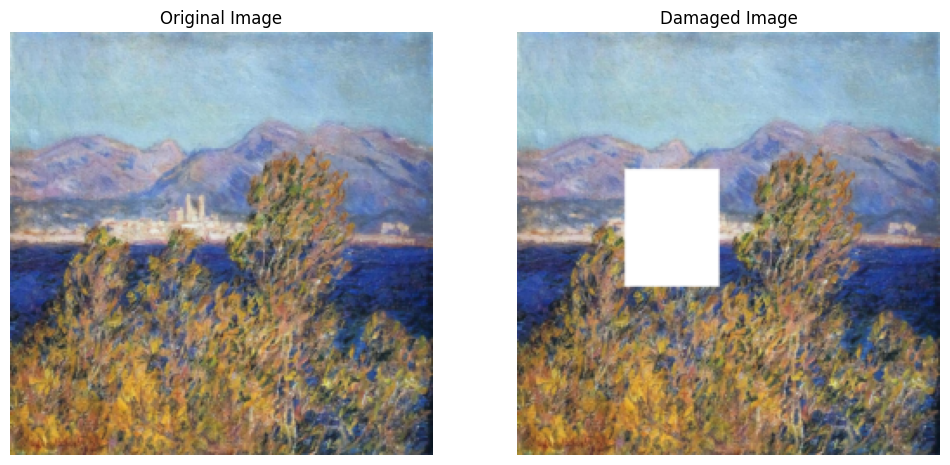

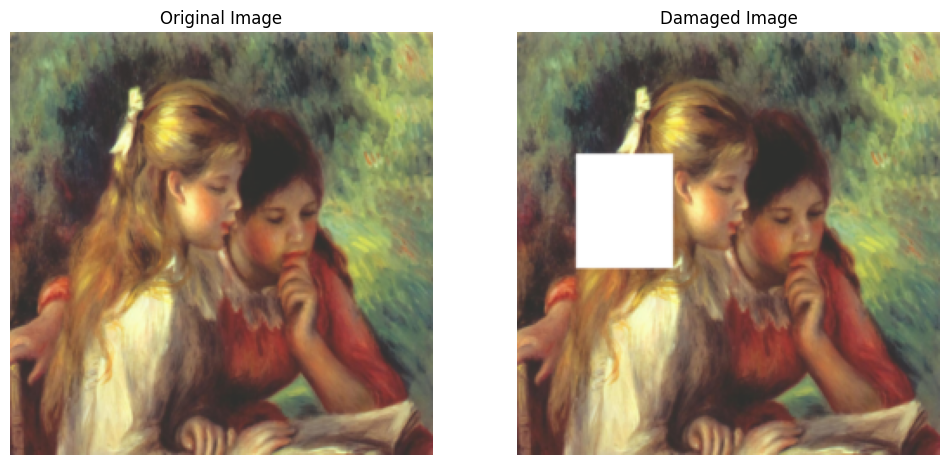

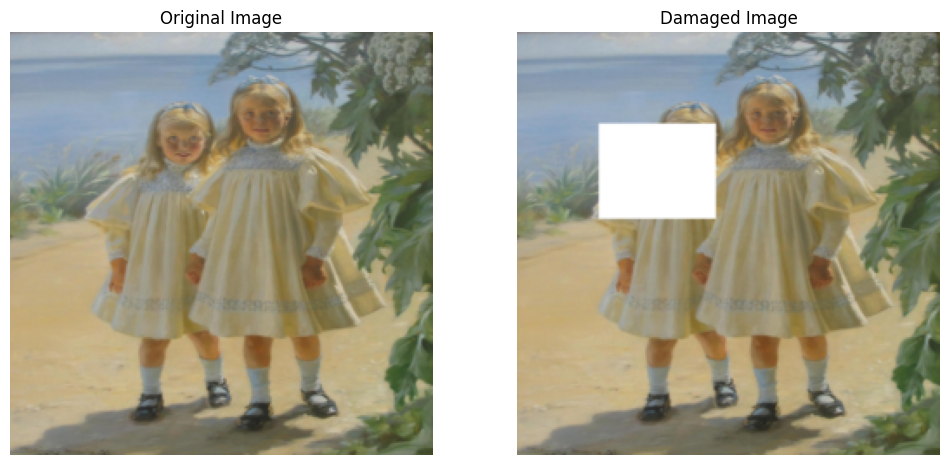

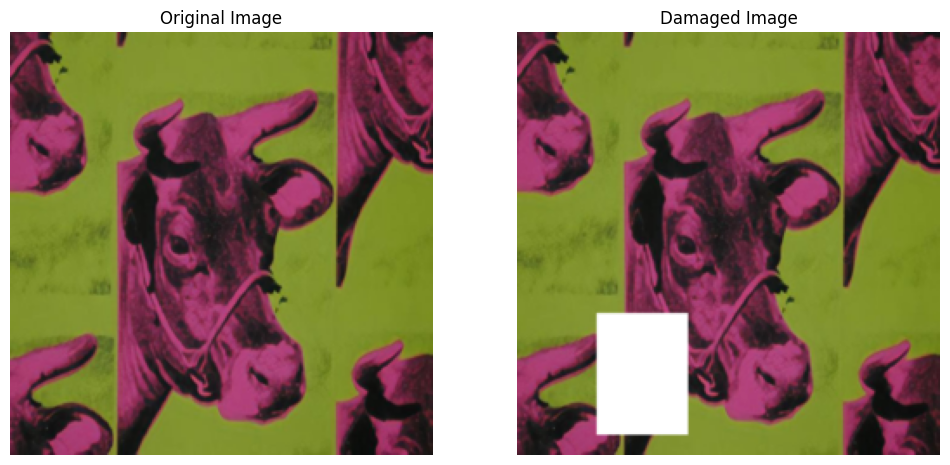

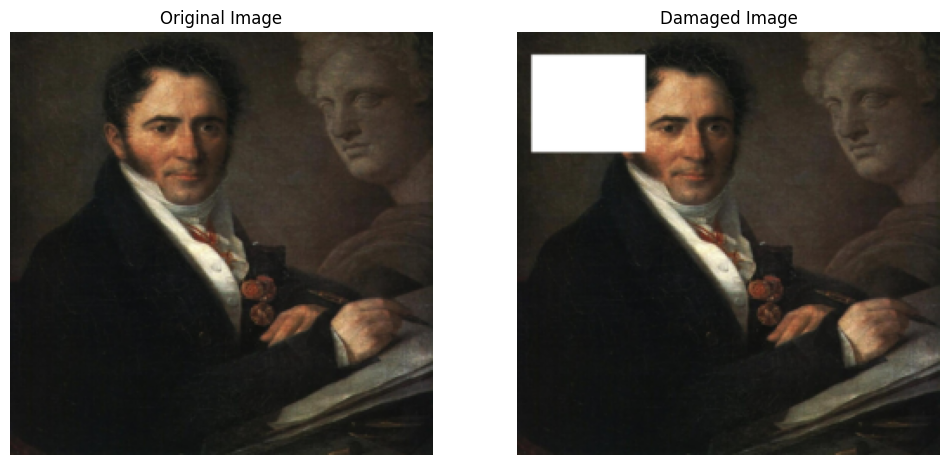

In [129]:
for i in range(5):
    original_image, damaged_image = test_dataset[i]
    display_images(original_image, damaged_image)

## FEATURE EXTRACTION AND REDUCTION

In [130]:
def extract_and_reduce_features_from_image(original_image, model, pca, print_details=False):
    # Add batch size for eval
    if len(original_image.shape) == 3:
        original_image = original_image.unsqueeze(0)
     
    reduced_latent_space = None
    model.to(device)

    try:
        # Extract latent space
        model.eval()  
        with torch.no_grad():
            original_image = original_image.to(device)
            latent_space = modified_resnet(original_image).cpu().numpy()

        reduced_latent_space = pca.transform(latent_space)
        
        if print_details:
            # Print the latent space
            print("Latent space representation:", latent_space)

            # Reduce the latent space to 102 dimensions using PCA
            print("Reduced latent space representation:", reduced_latent_space)

    except Exception as e:
        print(f"Error processing image: {e}")

    return latent_space, reduced_latent_space


In [162]:
import random
random_num = random.randint(0, len(test_dataset)-1)

test_image = test_dataset[random_num][0]
pca_model_path = "pca_4_components_200_michal.pkl"
pca = joblib.load(pca_model_path)

latent_space, reduced_latent_space = extract_and_reduce_features_from_image(test_image, modified_resnet, pca, print_details=False)
latent_space.shape, reduced_latent_space.shape

((1, 200), (1, 97))

## ASSIGN CLUSTER TO TEST IMAGE

C:\Users\Hyperbook\AppData\Local\Temp\ipykernel_18892\3821480569.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('coolwarm', len(unique_labels))


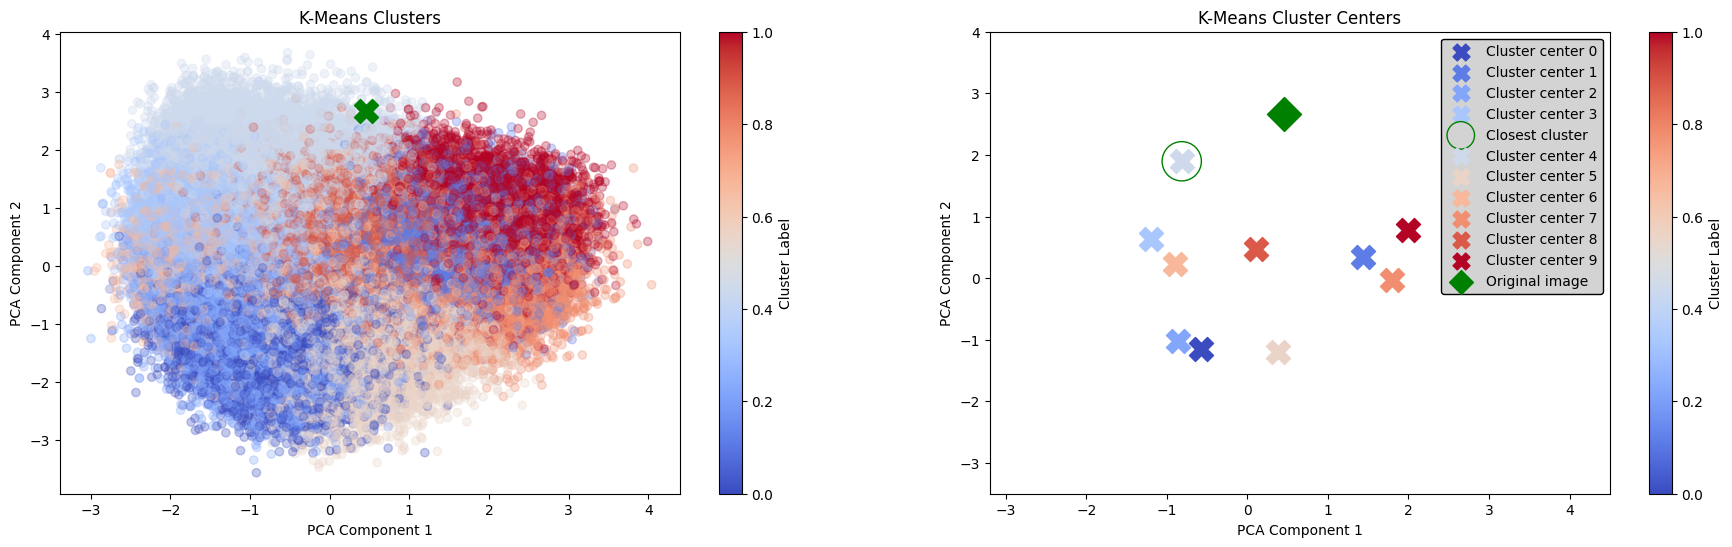

In [169]:


def assign_cluster_with_visualization(original_image, model, kmeans, pca, reduced_latent_vectors):

    try:

        latent_space, reduced_latent_space = extract_and_reduce_features_from_image(original_image, model, pca)

        # Cluster centers
        cluster_centers = kmeans.cluster_centers_

        # Distances between latent image reduced latent space and cluster centers
        distances = np.linalg.norm(cluster_centers - reduced_latent_space, axis=1)

        # Closest cluster
        closest_cluster = np.argmin(distances)
        shortest_distance = min(distances)

        # Visualization
        # Using PCA for visualization
        pca_2d = PCA(n_components=2)

        # Reduced vectors
        reduced_vectors_2d = pca_2d.fit_transform(reduced_latent_vectors)

        # Cluster centers
        cluster_centers = kmeans.cluster_centers_
        reduced_centers_2d = pca_2d.transform(cluster_centers)

        # Original image
        original_image_2d = pca_2d.transform(reduced_latent_space)
        original_image_2d = original_image_2d.flatten()

        # Labels and colors
        unique_labels = np.unique(labels)
        colors = plt.cm.get_cmap('coolwarm', len(unique_labels))  

        # Clusters
        plt.figure(figsize=(22, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(reduced_vectors_2d[:, 0], reduced_vectors_2d[:, 1], c=labels, cmap='coolwarm', marker='o', alpha=0.3)
        plt.scatter(original_image_2d[0], original_image_2d[1], c="green", marker="X", s=300)
        plt.title('K-Means Clusters')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar(label='Cluster Label')

        plt.subplot(1,2,2)
        # Dodanie centrów klastrów z odpowiednimi kolorami
        for i, center in enumerate(reduced_centers_2d):
            if i == closest_cluster:
                plt.scatter(center[0], center[1], color="green", facecolor="none", marker='o', s=800, label="Closest cluster")
            plt.scatter(center[0], center[1], color=colors(i), marker='X', s=300, label=f"Cluster center {i}")
        # Original image
        plt.scatter(original_image_2d[0], original_image_2d[1], c="green", marker="D", s=300, label="Original image")
        
        # Cluster Centers
        plt.set_cmap("coolwarm")
        plt.title('K-Means Cluster Centers')
        plt.xlim((-3.2, 4.5))
        plt.ylim((-3.5, 4))
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar(label='Cluster Label')
        # Legend
        legend = plt.legend(loc='upper right',  fontsize=10, facecolor='lightgrey', edgecolor='black', framealpha=1, markerscale=0.7)
        plt.show()

        
    except Exception as e:
        print(f"Error assigning test image to a cluster: {e}")
        
reduced_latent_vectors = np.load("reduced_latent_vectors_200_michal.npy")

# Example usage (ensure `test_image_reduced_latent_space` is properly defined):
assigned_cluster = assign_cluster_with_visualization(test_image, modified_resnet, kmeans, pca, reduced_latent_vectors)

## 3D VISUALIZATION

C:\Users\Hyperbook\AppData\Local\Temp\ipykernel_18892\2995954876.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('coolwarm', len(unique_labels))


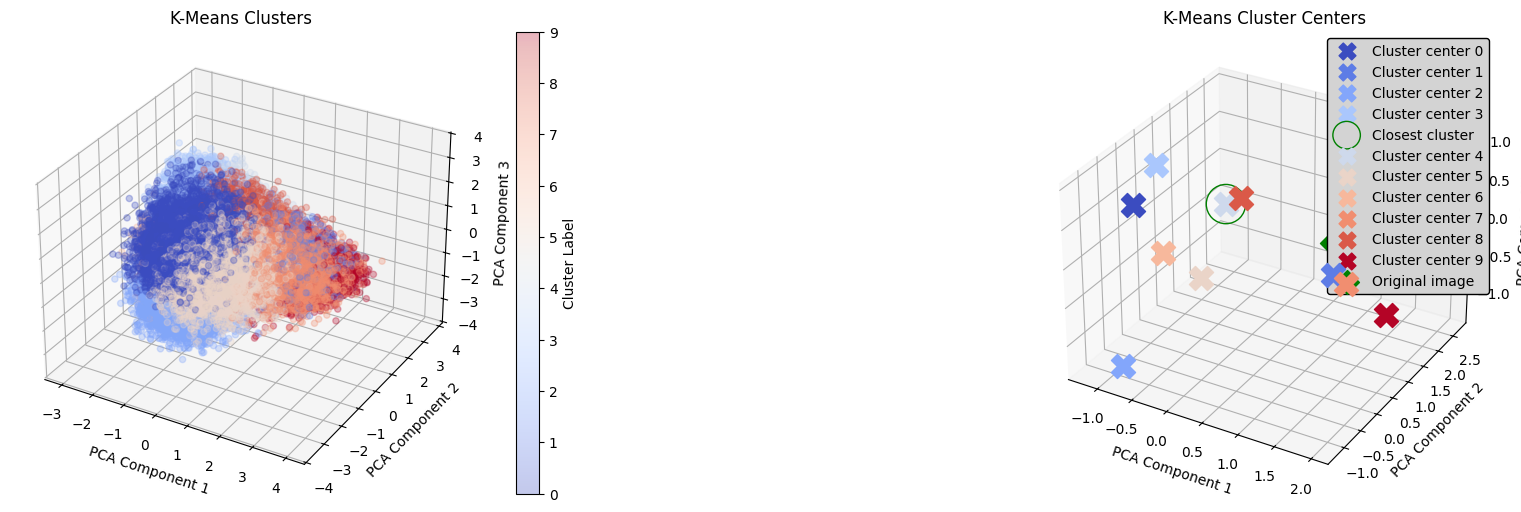

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting
from sklearn.decomposition import PCA
import matplotlib.cm as cm

def assign_cluster_with_visualization(original_image, model, kmeans, pca, reduced_latent_vectors):
    try:
        latent_space, reduced_latent_space = extract_and_reduce_features_from_image(original_image, model, pca)

        # Cluster centers
        cluster_centers = kmeans.cluster_centers_

        # Distances between latent image reduced latent space and cluster centers
        distances = np.linalg.norm(cluster_centers - reduced_latent_space, axis=1)

        # Closest cluster
        closest_cluster = np.argmin(distances)
        shortest_distance = min(distances)

        # Visualization
        # Using PCA for visualization
        pca_3d = PCA(n_components=3)

        # Reduced vectors
        reduced_vectors_3d = pca_3d.fit_transform(reduced_latent_vectors)

        # Cluster centers
        cluster_centers = kmeans.cluster_centers_
        reduced_centers_3d = pca_3d.transform(cluster_centers)

        # Original image
        original_image_3d = pca_3d.transform(reduced_latent_space)
        original_image_3d = original_image_3d.flatten()

        # Labels and colors
        unique_labels = np.unique(labels)
        colors = plt.cm.get_cmap('coolwarm', len(unique_labels))

        # Create 3D figure
        fig = plt.figure(figsize=(25, 6))
        ax1 = fig.add_subplot(121, projection='3d')  # 3D plot for clusters
        scatter1 = ax1.scatter(reduced_vectors_3d[:, 0], reduced_vectors_3d[:, 1], reduced_vectors_3d[:, 2], c=labels, cmap='coolwarm', marker='o', alpha=0.3)
        ax1.scatter(original_image_3d[0], original_image_3d[1], original_image_3d[2], c="green", marker="X", s=300)
        ax1.set_title('K-Means Clusters')
        ax1.set_xlabel('PCA Component 1')
        ax1.set_ylabel('PCA Component 2')
        ax1.set_zlabel('PCA Component 3')

        # Add colorbar for the first scatter plot
        cbar = plt.colorbar(scatter1, ax=ax1, label='Cluster Label')

        ax2 = fig.add_subplot(122, projection='3d')  # 3D plot for cluster centers
        for i, center in enumerate(reduced_centers_3d):
            if i == closest_cluster:
                ax2.scatter(center[0], center[1], center[2], color="green", facecolor="none", marker='o', s=800, label="Closest cluster")
            ax2.scatter(center[0], center[1], center[2], color=colors(i), marker='X', s=300, label=f"Cluster center {i}")

        # Original image
        ax2.scatter(original_image_3d[0], original_image_3d[1], original_image_3d[2], c="green", marker="D", s=300, label="Original image")

        ax2.set_title('K-Means Cluster Centers')
        ax2.set_xlabel('PCA Component 1')
        ax2.set_ylabel('PCA Component 2')
        ax2.set_zlabel('PCA Component 3')

        # Legend
        legend = ax2.legend(loc='upper right', fontsize=10, facecolor='lightgrey', edgecolor='black', framealpha=1, markerscale=0.7)
        
        plt.show()

    except Exception as e:
        print(f"Error assigning test image to a cluster: {e}")

# Load reduced latent vectors
reduced_latent_vectors = np.load("reduced_latent_vectors_200_michal.npy")

# Example usage (ensure `test_image_reduced_latent_space` is properly defined):
assigned_cluster = assign_cluster_with_visualization(test_image, modified_resnet, kmeans, pca, reduced_latent_vectors)


C:\Users\Adas\AppData\Local\Temp\ipykernel_14596\4028970537.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)
C

Test image assigned to cluster: 6
Loading autoencoder weights from: inpainting_autoencoder_cluster_6_done.pth
damage_image_tensor: torch.Size([1, 3, 224, 224])


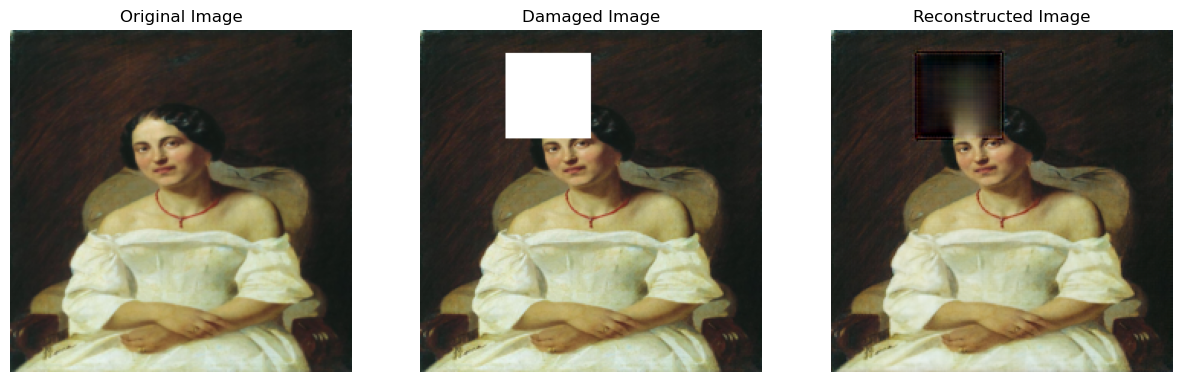

In [125]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image


#try this auto:

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)  # Add skip connection

class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
            nn.ReLU()
        )

        # Bottleneck with extended capacity and residual learning
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
            nn.ReLU(),
            ResidualBlock(1024, 1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
            nn.ReLU(),
            ResidualBlock(1024, 1024)
        )

        # Decoder with skip connections and residual blocks
        self.decoder = nn.ModuleDict({
            "deconv4": nn.Sequential(
                nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                nn.ReLU(),
                ResidualBlock(256, 256)
            ),
            "deconv3": nn.Sequential(
                nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                nn.ReLU(),
                ResidualBlock(128, 128)
            ),
            "deconv2": nn.Sequential(
                nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                nn.ReLU(),
                ResidualBlock(64, 64)
            ),
            "deconv1": nn.Sequential(
                nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                nn.Tanh()  # If you normalize inputs to [-1, 1]
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        bottleneck = self.bottleneck(enc4)  # 1024x7x7

        # Decode with skip connections
        dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
        dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
        dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
        dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224

        return bottleneck, dec1


# Function to preprocess a PIL.Image.Image into a tensor
def preprocess_image(image, image_size=(224, 224)):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),  # Resize to the expected input size
        transforms.ToTensor(),         # Convert to tensor
    ])
    return preprocess(image).unsqueeze(0)  # Add batch dimension

# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged)
    axes[1].set_title('Damaged Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()


# Initialize the autoencoder and reconstruct the image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = InpaintingAutoencoder()

# Load the autoencoder weights
checkpoint = torch.load(weights_path, map_location=device)
autoencoder.load_state_dict(checkpoint['model_state_dict'])
autoencoder = autoencoder.to(device)
autoencoder.eval()


weights_path = f"inpainting_autoencoder_cluster_{nearest_cluster}_done.pth"
print(f"Loading autoencoder weights from: {weights_path}")

# Preprocess images
original_image_tensor = preprocess_image(original_image)
damaged_image_tensor = preprocess_image(test_image)
            
# Move the damaged image to the correct device and reconstruct it
damaged_image_tensor = damaged_image_tensor.to(device)
_, reconstructed_image_tensor = autoencoder(damaged_image_tensor)
            
# Visualize the result
visualize_images(original_image_tensor, damaged_image_tensor, reconstructed_image_tensor)


